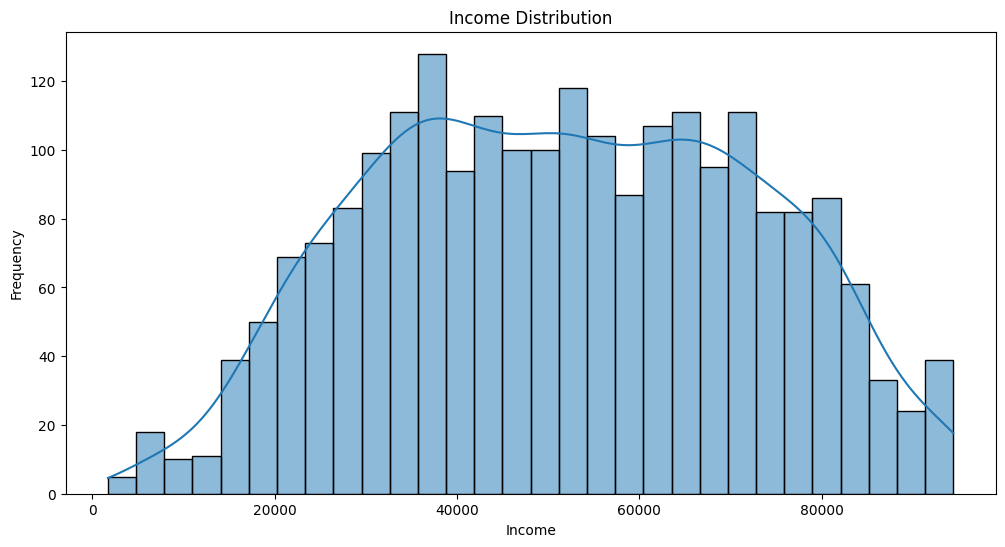

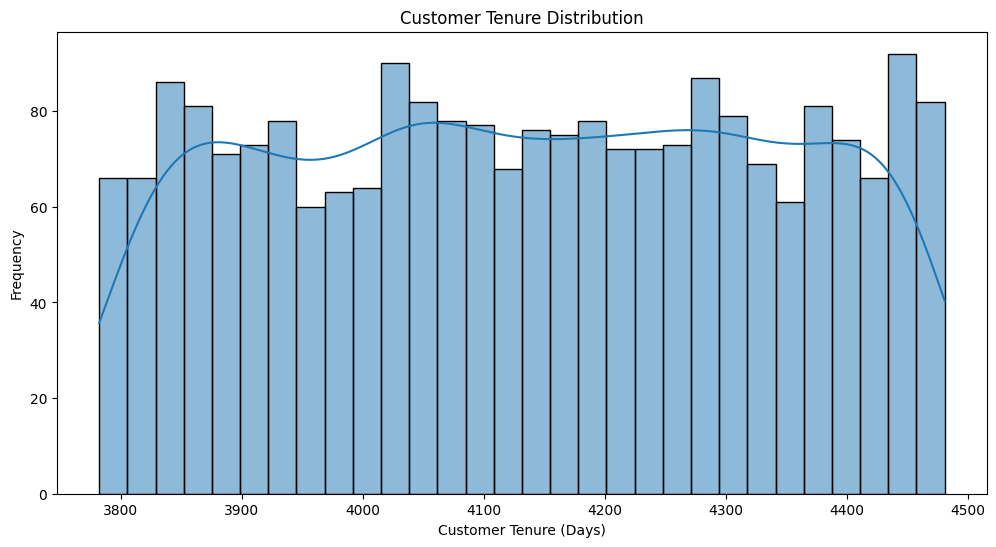

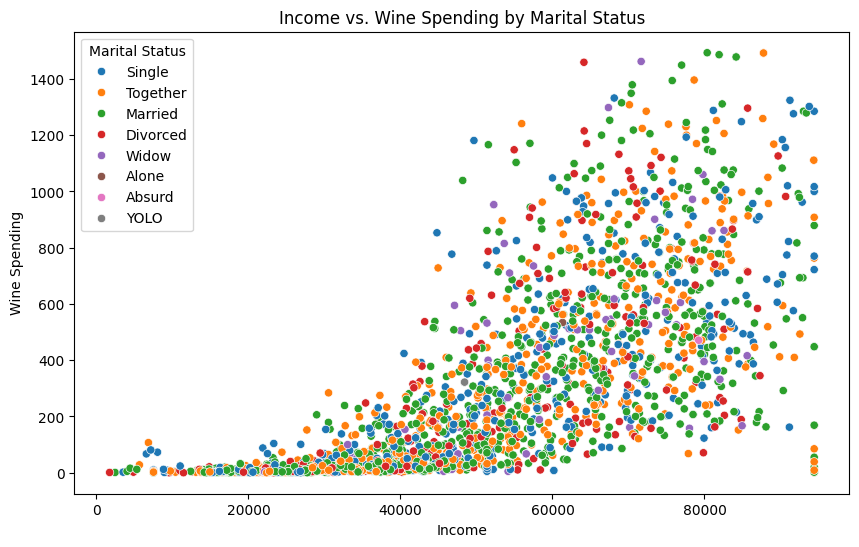

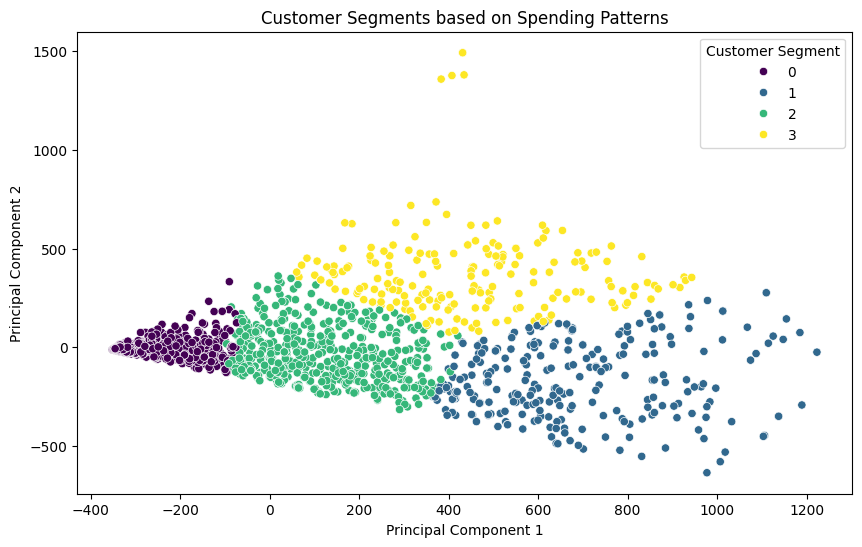

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
data = pd.read_csv('pds_alt_dataset.csv')
data['Income'] = data['Income'].fillna(data['Income'].median())
income_cap = data['Income'].quantile(0.99)
data['Income'] = data['Income'].apply(lambda x: min(x, income_cap))
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], dayfirst=True)
data['Customer_Tenure'] = (pd.Timestamp("today") - data['Dt_Customer']).dt.days
data = data.drop(columns=['Dt_Customer'])

plt.figure(figsize=(12, 6))
sns.histplot(data['Income'], bins=30, kde=True)
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data['Customer_Tenure'], bins=30, kde=True)
plt.title('Customer Tenure Distribution')
plt.xlabel('Customer Tenure (Days)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Income', y='MntWines', hue='Marital_Status', data=data)
plt.title('Income vs. Wine Spending by Marital Status')
plt.xlabel('Income')
plt.ylabel('Wine Spending')
plt.legend(title='Marital Status')
plt.show()

spending_features = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
kmeans = KMeans(n_clusters=4, random_state=42)
data['Customer_Segment'] = kmeans.fit_predict(data[spending_features])

pca = PCA(n_components=2)
spending_pca = pca.fit_transform(data[spending_features])
data['PC1'] = spending_pca[:, 0]
data['PC2'] = spending_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Customer_Segment', palette='viridis', data=data)
plt.title('Customer Segments based on Spending Patterns')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Customer Segment')
plt.show()

X = data.drop(columns=['NumWebPurchases', 'ID', 'PC1', 'PC2'])  
y = data['NumWebPurchases']

In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import optuna

X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_prepared = scaler.fit_transform(X_train)
X_test_prepared = scaler.transform(X_test)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    return cross_val_score(rf, X_train_prepared, y_train, n_jobs=-1, cv=5, scoring='neg_mean_squared_error').mean()

study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=10)

print("Best Parameters:", study.best_params)
print("Best Negative MSE Score:", study.best_value)

best_rf = RandomForestRegressor(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    min_samples_split=study.best_params['min_samples_split'],
    min_samples_leaf=study.best_params['min_samples_leaf'],
    max_features=study.best_params['max_features'],
    random_state=42
)

best_rf.fit(X_train_prepared, y_train)

y_pred = best_rf.predict(X_test_prepared)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Optimized Random Forest Model Results:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

/home/cyclops/Downloads/div help/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-05 20:09:54,782] A new study created in memory with name: no-name-d1d0c40e-cc44-42b6-8bc9-479ff8021d99
[I 2024-11-05 20:09:56,090] Trial 0 finished with value: -2.776914864291242 and parameters: {'n_estimators': 429, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: -2.776914864291242.
[I 2024-11-05 20:09:57,663] Trial 1 finished with value: -2.4252519433811157 and parameters: {'n_estimators': 213, 'max_depth': 46, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 1 with value: -2.4252519433811157.
[I 2024-11-05 20:09:58,360] Trial 2 finished with value: -2.8778700478212627 and parameters: {'n_estimators': 16

Best Parameters: {'n_estimators': 213, 'max_depth': 46, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None}
Best Negative MSE Score: -2.4252519433811157
Optimized Random Forest Model Results:
Mean Squared Error (MSE): 1.846755405830067
R² Score: 0.7434384077854111


In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib  

X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_prepared = scaler.fit_transform(X_train)
X_test_prepared = scaler.transform(X_test)

best_params = {
    'n_estimators': 344,
    'max_depth': 21,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': None
}

best_rf = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42
)

best_rf.fit(X_train_prepared, y_train)

y_pred = best_rf.predict(X_test_prepared)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Optimized Random Forest Model Results:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

joblib.dump(best_rf, 'optimized_random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X_encoded.columns, 'training_columns.pkl')


Optimized Random Forest Model Results:
Mean Squared Error (MSE): 1.8536476370309174
R² Score: 0.7424809004700303


['training_columns.pkl']